# Connected Driver PySpark ML

## Create the Spark Context 

In [1]:
fixedDate = "2019-02-12"
TABLE = "/obd/obd_raw_table"
APP_NAME = "Connected Car ML"

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

from pyspark.sql.functions import *
import numpy as np

spark = SparkSession.builder \
    .appName(APP_NAME) \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

## Import the Data from MapR DB into a Spark DataFrame

In [2]:
df1 = sqlContext.read\
     .format("com.mapr.db.spark.sql.DefaultSource")\
     .option("tableName", TABLE).load()

df1.printSchema()
print("Total number of rows: %d" % df1.count())

root
 |-- _id: string (nullable = true)
 |-- altitude: string (nullable = true)
 |-- ambientAirTemperature: string (nullable = true)
 |-- engineCoolant: string (nullable = true)
 |-- fuelRate: string (nullable = true)
 |-- hrTimeStamp: string (nullable = true)
 |-- instantFuelEconomy: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- make: string (nullable = true)
 |-- nhrTimeStamp: string (nullable = true)
 |-- odometer: string (nullable = true)
 |-- rpm: string (nullable = true)
 |-- speed: string (nullable = true)
 |-- target: string (nullable = true)
 |-- throttle: string (nullable = true)
 |-- timeSinceEngineStart: string (nullable = true)
 |-- totalFuelEconomy: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- year: string (nullable = true)

Total number of rows: 100000


## Use matplotlib to explore some of the fields visually. 
### In the figure below, we are showing number of samples for each VIN

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

def display_field(field,title,in_df): 
  responses = in_df.groupBy(field).count().collect()
  categories = [i[0] for i in responses]
  counts = [i[1] for i in responses]
 
  ind = np.array(range(len(categories)))
  width = 0.35
  plt.bar(ind, counts, width=width, color='r')
 
  plt.ylabel('counts')
  plt.title(title)
  plt.xticks(ind + width/2., categories)

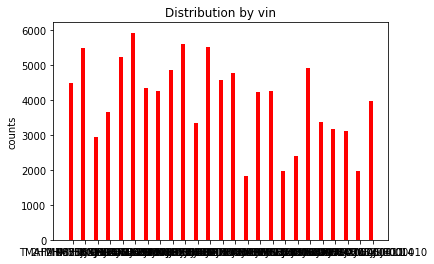

In [4]:
display_field('vin','Distribution by vin', df1)

# Feature Engineering

### Select Unique VIN / Date Combination
### Compute Correlation between Engine RPM and Engine Coolant Temperature

In [5]:
df2 = df1.groupby('vin', date_format('hrTimeStamp', 'yyyy-MM-dd').alias('date')).agg(corr("rpm","engineCoolant").alias('r'))
df2.orderBy("date").show(df2.count())

+-----------------+----------+--------------------+
|              vin|      date|                   r|
+-----------------+----------+--------------------+
|KMHKAHMX8J8000001|2019-01-25|  0.6204097635773742|
|TMAPAU5A5JE000010|2019-01-25| 0.48055876777686585|
|KMHKV17UXJW000011|2019-01-25|   0.601338201299891|
|TMAHR6BH2JR000002|2019-01-26| 0.49394325755957413|
|TMAHM5EJ0JB000015|2019-01-27| 0.36300056368682115|
|KMHFJDM99JU000012|2019-01-27|  0.6684184271832342|
|9BHC6F6Z2JM000013|2019-01-27|  0.6630305389517865|
|2HMH87FM5JJ000014|2019-01-27| 0.30053764251227544|
|2HML79P87JY000016|2019-01-28|  0.5686025464232229|
|TMAKC7N27JT000018|2019-01-28|  0.7182310247380524|
|2HMPNRBF2JB000019|2019-01-28|  0.6705417140987361|
|2HMDJJFB2JJ000017|2019-01-28|  0.6206873381664192|
|TMAL9T6BXJD000003|2019-01-28|  0.6661904589394555|
|2HMHM3T8XJP000020|2019-01-29|  0.6719088048375752|
|TMAFMR6Y5JK000022|2019-01-29|-0.09080050995681153|
|9BHH1X2XXJR000021|2019-01-29|-0.20827343367849155|
|2HMD8CFW9J2

### Collect Target Events (Past Engine Failures that Required Service)

In [6]:
df3 = df1.groupby('vin', date_format('hrTimeStamp', 'yyyy-MM-dd').alias('date')).agg({"target": "max"})

### Join DataFrames into Feature Table

In [7]:
feature_table = df2.join(df3, ["vin", "date"]).select('vin', 'date', 'r', col("max(target)").alias("engineFailure"))

In [8]:
feature_table.printSchema()
print("Total number of rows: %d" % feature_table.count())
feature_table.orderBy("date").show(feature_table.count())

root
 |-- vin: string (nullable = true)
 |-- date: string (nullable = true)
 |-- r: double (nullable = true)
 |-- engineFailure: string (nullable = true)

Total number of rows: 75
+-----------------+----------+--------------------+-------------+
|              vin|      date|                   r|engineFailure|
+-----------------+----------+--------------------+-------------+
|KMHKAHMX8J8000001|2019-01-25|  0.6204097635773742|            0|
|TMAPAU5A5JE000010|2019-01-25| 0.48055876777686585|            0|
|KMHKV17UXJW000011|2019-01-25|   0.601338201299891|            0|
|TMAHR6BH2JR000002|2019-01-26| 0.49394325755957413|            0|
|TMAHM5EJ0JB000015|2019-01-27| 0.36300056368682115|            0|
|KMHFJDM99JU000012|2019-01-27|  0.6684184271832342|            0|
|2HMH87FM5JJ000014|2019-01-27| 0.30053764251227544|            0|
|9BHC6F6Z2JM000013|2019-01-27|  0.6630305389517865|            0|
|2HMPNRBF2JB000019|2019-01-28|  0.6705417140987361|            0|
|2HMDJJFB2JJ000017|2019-01-2

In [9]:
feature_table.createOrReplaceTempView("feature_table_view")

## Build Model to Predict Engine Failure (1=yes)
### The graph below shows that this is an unbalanced classification problem

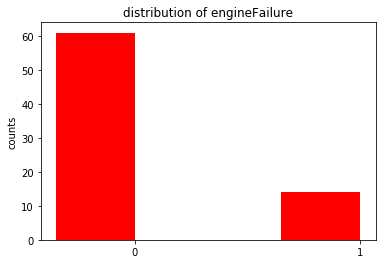

In [10]:
display_field('engineFailure','distribution of engineFailure', feature_table)

## Import functions needed to prepare data, train model, and visualize results

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## Prepare the data for training the ML Ensemble
### select historical, predictive features (e.g. correlation between Engine RPM and Engine Coolant Temperature, etc.)
### assign engineFailure as the target

In [12]:
myFeatures = ['r']
# put data in the format that many Spark ML algorithms require
assembler_features = VectorAssembler(inputCols=myFeatures, outputCol='features')
labelIndexer = StringIndexer(inputCol='engineFailure', outputCol="label")
tmp = [assembler_features, labelIndexer]
pipeline = Pipeline(stages=tmp)

### Apply pipeline to the data and view result ###

In [13]:
allData = pipeline.fit(feature_table).transform(feature_table.fillna(0))
allData.cache() # Create object in memory if possible, if not write to disk
allData.select('label','features').show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[-0.1522430638405...|
|  0.0|[0.7496551848201037]|
|  0.0|[0.6013825241373006]|
|  0.0|[0.7445019690192016]|
|  0.0|[0.7112960693885785]|
|  0.0|  [0.33603375553991]|
|  0.0|[0.7182310247380524]|
|  1.0|[-0.1111501678138...|
|  0.0|[0.36190413715711...|
|  0.0|[0.7288418308191142]|
|  0.0|[0.6401804947869251]|
|  0.0|[0.5119191048196033]|
|  0.0|[0.7292679969712536]|
|  1.0|[0.14094005032076...|
|  0.0|[0.6230629646808952]|
|  0.0|[0.6705417140987361]|
|  0.0|[0.6295825105901686]|
|  0.0|[0.4199019550783692]|
|  0.0|[0.5134027879929708]|
|  1.0|[-0.1053216867361...|
+-----+--------------------+
only showing top 20 rows



### Split data into training and testing

### Assign Training Data

In [14]:
#trainingDF = sqlContext.sql('SELECT * FROM feature_table_view WHERE date < CURRENT_DATE')
query = "SELECT * FROM feature_table_view WHERE date < '{}'".format(fixedDate)
trainingDF = sqlContext.sql(query)
trainingData = pipeline.fit(trainingDF).transform(trainingDF.fillna(0))
trainingData.cache() # Create object in memory if possible, if not write to disk

print("Total number of rows: %d" % trainingData.count())
print("Distribution of Pos and Neg in trainingData is: ", trainingData.groupBy("label").count().take(3))
trainingData.show(trainingData.count())

Total number of rows: 61
Distribution of Pos and Neg in trainingData is:  [Row(label=0.0, count=49), Row(label=1.0, count=12)]
+-----------------+----------+--------------------+-------------+--------------------+-----+
|              vin|      date|                   r|engineFailure|            features|label|
+-----------------+----------+--------------------+-------------+--------------------+-----+
|2HMDJJFB2JJ000017|2019-02-11|-0.15224306384056052|            1|[-0.1522430638405...|  1.0|
|2HMPNRBF2JB000019|2019-02-11|  0.7445019690192016|            0|[0.7445019690192016]|  0.0|
|2HMDJJFB2JJ000017|2019-02-07|  0.7112960693885785|            0|[0.7112960693885785]|  0.0|
|TMAKC7N27JT000018|2019-01-28|  0.7182310247380524|            0|[0.7182310247380524]|  0.0|
|9BHDJ3XW4J1000005|2019-02-03|-0.11115016781381373|            1|[-0.1111501678138...|  1.0|
|KMHFJDM99JU000012|2019-02-11| 0.36190413715711234|            0|[0.36190413715711...|  0.0|
|9BHHZT2T2J7000007|2019-01-31|  0.72

### Assign Test Data

In [15]:
#testDF = sqlContext.sql('SELECT * FROM feature_table_view WHERE date = CURRENT_DATE')
query = "SELECT * FROM feature_table_view WHERE date = '{}'".format(fixedDate)
testDF = sqlContext.sql(query)
testDF.show(testDF.count())

+-----------------+----------+--------------------+-------------+
|              vin|      date|                   r|engineFailure|
+-----------------+----------+--------------------+-------------+
|9BHCU3KB0JG000006|2019-02-12|  0.7496551848201037|            0|
|TMAHM5EJ0JB000015|2019-02-12|    0.33603375553991|            0|
|9BHH1X2XXJR000021|2019-02-12|  0.7092346403588329|            0|
|2HML79P87JY000016|2019-02-12| 0.45573677590923173|            0|
|9BHHZT2T2J7000007|2019-02-12|    0.73757826664576|            0|
|TMAHHRMC6JZ000008|2019-02-12|  0.6766468915348985|            0|
|TMAFMR6Y5JK000022|2019-02-12|  0.5149344687464396|            0|
|2HMH87FM5JJ000014|2019-02-12| 0.47098955252431296|            0|
|TMAPAU5A5JE000010|2019-02-12|  0.6330546036408093|            0|
|9BHDJ3XW4J1000005|2019-02-12|  0.5752567006129752|            0|
|2HMDJJFB2JJ000017|2019-02-12|-0.01666701871772...|            1|
+-----------------+----------+--------------------+-------------+



In [16]:
testData = pipeline.fit(testDF).transform(testDF.fillna(0))
testData.cache() # Create object in memory if possible, if not write to disk

print("Total number of rows: %d" % testData.count())
print("Distribution of Pos and Neg in trainingData is: ", testData.groupBy("label").count().take(3))
testData.show(testData.count())

Total number of rows: 11
Distribution of Pos and Neg in trainingData is:  [Row(label=0.0, count=10), Row(label=1.0, count=1)]
+-----------------+----------+--------------------+-------------+--------------------+-----+
|              vin|      date|                   r|engineFailure|            features|label|
+-----------------+----------+--------------------+-------------+--------------------+-----+
|9BHCU3KB0JG000006|2019-02-12|  0.7496551848201037|            0|[0.7496551848201037]|  0.0|
|TMAHM5EJ0JB000015|2019-02-12|    0.33603375553991|            0|  [0.33603375553991]|  0.0|
|9BHH1X2XXJR000021|2019-02-12|  0.7092346403588329|            0|[0.7092346403588329]|  0.0|
|2HML79P87JY000016|2019-02-12| 0.45573677590923173|            0|[0.45573677590923...|  0.0|
|9BHHZT2T2J7000007|2019-02-12|    0.73757826664576|            0|  [0.73757826664576]|  0.0|
|TMAHHRMC6JZ000008|2019-02-12|  0.6766468915348985|            0|[0.6766468915348985]|  0.0|
|TMAFMR6Y5JK000022|2019-02-12|  0.514

## Train Supervised Learning Models

### Random Forest

In [17]:
rf = RF(labelCol='label', featuresCol='features', numTrees=200)
fitRF = rf.fit(trainingData)

### Use Logistic Regression

In [18]:
lr = LogisticRegression(maxIter=10, regParam=0.01) 
fitLR = lr.fit(trainingData)

### Use Logistic Coefficients to Interpret the Model

In [19]:
print("Intercept: " + str(fitLR.intercept))

for i in range(0,len(fitLR.coefficients)):
    print(myFeatures[i], fitLR.coefficients[i])

Intercept: 1.664310586351182
r -9.43717150769806


## Apply models to the test set

### Random Forest

In [20]:
transformedRF = fitRF.transform(testData)

In [21]:
transformedRF.select('vin','engineFailure','label','probability','prediction').show()

+-----------------+-------------+-----+--------------------+----------+
|              vin|engineFailure|label|         probability|prediction|
+-----------------+-------------+-----+--------------------+----------+
|9BHCU3KB0JG000006|            0|  0.0|           [1.0,0.0]|       0.0|
|TMAHM5EJ0JB000015|            0|  0.0|           [1.0,0.0]|       0.0|
|9BHH1X2XXJR000021|            0|  0.0|           [1.0,0.0]|       0.0|
|2HML79P87JY000016|            0|  0.0|           [1.0,0.0]|       0.0|
|9BHHZT2T2J7000007|            0|  0.0|           [1.0,0.0]|       0.0|
|TMAHHRMC6JZ000008|            0|  0.0|           [1.0,0.0]|       0.0|
|TMAFMR6Y5JK000022|            0|  0.0|           [1.0,0.0]|       0.0|
|2HMH87FM5JJ000014|            0|  0.0|           [1.0,0.0]|       0.0|
|TMAPAU5A5JE000010|            0|  0.0|           [1.0,0.0]|       0.0|
|9BHDJ3XW4J1000005|            0|  0.0|           [1.0,0.0]|       0.0|
|2HMDJJFB2JJ000017|            1|  1.0|[0.01783333333333...|    

### Use Logistic Regression

In [22]:
transformedLR = fitLR.transform(testData)

In [23]:
transformedLR.select('vin','engineFailure','label','probability','prediction').show()

+-----------------+-------------+-----+--------------------+----------+
|              vin|engineFailure|label|         probability|prediction|
+-----------------+-------------+-----+--------------------+----------+
|9BHCU3KB0JG000006|            0|  0.0|[0.99554965758732...|       0.0|
|TMAHM5EJ0JB000015|            0|  0.0|[0.81860097570441...|       0.0|
|9BHH1X2XXJR000021|            0|  0.0|[0.99349629523056...|       0.0|
|2HML79P87JY000016|            0|  0.0|[0.93317749695552...|       0.0|
|9BHHZT2T2J7000007|            0|  0.0|[0.99501508733422...|       0.0|
|TMAHHRMC6JZ000008|            0|  0.0|[0.99117517208907...|       0.0|
|TMAFMR6Y5JK000022|            0|  0.0|[0.96065378552558...|       0.0|
|2HMH87FM5JJ000014|            0|  0.0|[0.94161286251820...|       0.0|
|TMAPAU5A5JE000010|            0|  0.0|[0.98674365896812...|       0.0|
|9BHDJ3XW4J1000005|            0|  0.0|[0.97734558508603...|       0.0|
|2HMDJJFB2JJ000017|            1|  1.0|[0.13924198434166...|    

## Calculate the AUC (Area-Under-the-Curve) for each Algorithm
### 1.0 is the highest AUC possible (perfect performance)
### 0.5 is performance acheived with random choice (worst performance)

In [24]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric

### Random Forest

In [25]:
resultsRF = transformedRF.select(['probability', 'label'])
results_collectRF = resultsRF.collect()
results_listRF = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collectRF]
scoreAndLabelsRF = sc.parallelize(results_listRF)
metricsRF = metric(scoreAndLabelsRF)
print("AUC score (RF with 200 trees): ", metricsRF.areaUnderROC)

AUC score (RF with 200 trees):  1.0


### Logistic Regression

In [26]:
resultsLR = transformedLR.select(['probability', 'label'])
results_collectLR = resultsLR.collect()
results_listLR = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collectLR]
scoreAndLabelsLR = sc.parallelize(results_listLR)
metricsLR = metric(scoreAndLabelsLR)
print("AUC score (Logistic Reg): ", metricsLR.areaUnderROC)

AUC score (Logistic Reg):  1.0


## Plot the ROC (Receiver Operating Characteristic) for Algorithms
### y=x line is random performance (AUC=0.5)

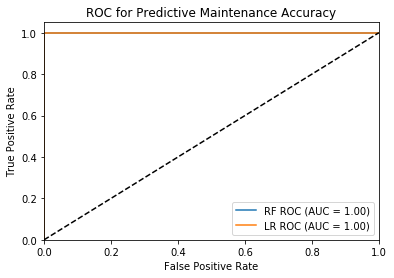

In [27]:
from sklearn.metrics import roc_curve, auc
 
### random forest    
fprRF = dict()
tprRF = dict()
roc_aucRF = dict()
y_testRF = [i[1] for i in results_listRF]
y_scoreRF = [i[0] for i in results_listRF]
fprRF, tprRF, _ = roc_curve(y_testRF, y_scoreRF)
roc_aucRF = auc(fprRF, tprRF)

### Logistic Regression
fprLR = dict()
tprLR = dict()
roc_aucLR = dict()
y_testLR = [i[1] for i in results_listLR]
y_scoreLR = [i[0] for i in results_listLR]
fprLR, tprLR, _ = roc_curve(y_testLR, y_scoreLR)
roc_aucLR = auc(fprLR, tprLR)
 
%matplotlib inline
plt.figure()
plt.plot(fprRF, tprRF, label='RF ROC (AUC = %0.2f)' % roc_aucRF)
plt.plot(fprLR, tprLR, label='LR ROC (AUC = %0.2f)' % roc_aucLR)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Predictive Maintenance Accuracy')
plt.legend(loc="lower right")
plt.show()

### Below we are looking at High Scores from the Random Forest Model
### Once a threshold is established based on the ROC, scores can be used to anticipate maintenance opportunties to avoid breakdowns...

In [28]:
scores = transformedRF.select('VIN','probability','label','r')

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
firstelement=udf(lambda v:float(v[1]),FloatType())
probs = scores.select('VIN','label','r',
  firstelement('probability').alias('probFailure')).orderBy('probFailure',ascending=False)
probs.show(probs.count())

+-----------------+-----+--------------------+-----------+
|              VIN|label|                   r|probFailure|
+-----------------+-----+--------------------+-----------+
|2HMDJJFB2JJ000017|  1.0|-0.01666701871772...| 0.98216665|
|9BHCU3KB0JG000006|  0.0|  0.7496551848201037|        0.0|
|TMAHM5EJ0JB000015|  0.0|    0.33603375553991|        0.0|
|9BHH1X2XXJR000021|  0.0|  0.7092346403588329|        0.0|
|2HML79P87JY000016|  0.0| 0.45573677590923173|        0.0|
|9BHHZT2T2J7000007|  0.0|    0.73757826664576|        0.0|
|TMAHHRMC6JZ000008|  0.0|  0.6766468915348985|        0.0|
|TMAFMR6Y5JK000022|  0.0|  0.5149344687464396|        0.0|
|2HMH87FM5JJ000014|  0.0| 0.47098955252431296|        0.0|
|TMAPAU5A5JE000010|  0.0|  0.6330546036408093|        0.0|
|9BHDJ3XW4J1000005|  0.0|  0.5752567006129752|        0.0|
+-----------------+-----+--------------------+-----------+



# Write Output Message to MapR DB

In [29]:
theOne = transformedRF.select('vin','prediction').filter("vin = '2HMDJJFB2JJ000017'").collect()

print("theOne: ", theOne[0])    #Row(vin=u'2HMDJJFB2JJ000017', prediction=1.0)

if ( theOne[0]['prediction'] == 1.0 ) :
 ## 2. Save to Messages Table
 from pyspark.sql import Row

 messages = [("99","2HMDJJFB2JJ000017", "02-13-2019", "Engine Status: OVERHEATING", "1")]
 rows = sc.parallelize(messages).map(lambda p: Row(_id=p[0], vin=p[1], date=p[2], message=p[3], severity=p[4]))
 dataframe = spark.createDataFrame(rows)
 dataframe.show()

 spark.saveToMapRDB(dataframe, "/obd/obd_messages", create_table=False)

theOne:  Row(vin='2HMDJJFB2JJ000017', prediction=1.0)
+---+----------+--------------------+--------+-----------------+
|_id|      date|             message|severity|              vin|
+---+----------+--------------------+--------+-----------------+
| 99|02-13-2019|Engine Status: OV...|       1|2HMDJJFB2JJ000017|
+---+----------+--------------------+--------+-----------------+

